# Post Earthquake Satellite Autotasking Project
This Jupyter Notebook will contain all code related to the accessing and tasking of satellites following an earthquake. The goal is to automate the process of image capture tasks for earthquake-affected areas using a satellite tasking API. Please replace 'SATELLITE' with your actual satellite tasking API provider for specific instructions.

## A Step-by-step tutorial of this process:

1. Create an account and access USGS Daily EarthQuake Notification
2. Use USGS API to filter earthquake in chosen area with specific characterisitics (ie. earthquake magnitude)
3. Extract the location (latitude and longitude) of the selected earthquake
4. Use jupyter notebook & Google Earth Engine to visualize its location, perform any geosptial analysis as fit, such as mapping the historical / potential impact
5. Inject the location as tasking / searching query in GEE to surface the most recent imagery

# Step 1: Set up correct enviornment 

In [63]:
!pip install requests folium google-earth-engine-api
!pip install earthengine-api
!pip install folium
!pip install geopandas matplotlib


import requests
import ee  # Google Earth Engine
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import datetime
from datetime import timedelta


ERROR: Could not find a version that satisfies the requirement google-earth-engine-api (from versions: none)
ERROR: No matching distribution found for google-earth-engine-api


# Step 2: Authenticate with Google Earth Engine


In [29]:

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AeaYSHCDew1I0hy7IhOjew0BpO2o-PO0uVjAmH6zQCVulEWIJTv8ZKHq2N0

Successfully saved authorization token.


# Step 3: Use USGS API to Filter Earthquakes

- USGS API Access: For programmatic access, the USGS provides an Earthquake Catalog API, which allows you to query their earthquake data. Information about the API and how to use it can be found on their API Documentation page.No Account Needed.

In [75]:
# Fetch earthquakes with magnitude 4.5+ worldwide from the past day
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2024-04-02&endtime=2024-04-03&minmagnitude=4.5'
response = requests.get(url)
data = response.json()
#print(data)


# Initialize the map outside the loop, centered on a default location
earthquake_map = folium.Map(location=[0, 0], zoom_start=2)

# Calculate start and end dates for a one-month window around the earthquake
start_date = earthquake_time - timedelta(days=60)
end_date = earthquake_time + timedelta(days=60)


# Loop through each earthquake to place markers
for earthquake in data['features']:
    place = earthquake['properties']['place']
    magnitude = earthquake['properties']['mag']
    time_ms = earthquake['properties']['time']  # Time in milliseconds
    earthquake_time = datetime.datetime.utcfromtimestamp(time_ms / 1000.0)  # Convert to datetime
    location = earthquake['geometry']['coordinates']
    latitude, longitude = location[1], location[0]

    # Print earthquake information
    print(f"{place}, Magnitude: {magnitude}")
    print(f"Latitude: {latitude}, Longitude: {longitude}")

    # Add a marker for each earthquake to the map
    folium.Marker(
        [latitude, longitude],
        tooltip=f"{place}, Magnitude: {magnitude}"
    ).add_to(earthquake_map)
    
    try:
        
        # Attempt to fetch a Landsat image that matches the location and is the closest to the event time
        collection = ee.ImageCollection('LANDSAT/LC08/C02/T2')\
                        .filterBounds(ee.Geometry.Point(longitude, latitude))\
                        .filterDate(start_date.strftime('%Y-%m-%d'),end_date.strftime('%Y-%m-%d'))\
                        .sort('system:time_start', True)  # True for ascending order
        image = collection.first() #pick the first (closest) imagery to the sorted imagery 

        # Check if the image is valid
        image_info = image.getInfo()  # This will throw an error if the image is not valid
        
        map_id_dict = ee.Image(image).getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 2000, 'max': 20000})
        
        # Only proceed if map_id_dict is successfully retrieved
        if map_id_dict:
            print("Image found, adding to map.")
            folium.TileLayer(
                tiles=map_id_dict['tile_fetcher'].url_format,
                attr='Map Data &copy; Google Earth Engine',
                overlay=True,
                name=f'Landsat 8 - {place}',
            ).add_to(earthquake_map)
    except Exception as e:
        print(f"No valid image found for {place}, skipping image layer. Error: {str(e)}")

# Display the map with all markers and valid images after the loop
earthquake_map


18 km SSW of Hualien City, Taiwan, Magnitude: 7.4
Latitude: 23.819, Longitude: 121.5616
Image found, adding to map.
11 km N of Yopal, Colombia, Magnitude: 4.9
Latitude: 5.4407, Longitude: -72.3855
No valid image found for 11 km N of Yopal, Colombia, skipping image layer. Error: Image.visualize: Parameter 'image' is required.
143 km ENE of Saipan, Northern Mariana Islands, Magnitude: 5.2
Latitude: 15.8873, Longitude: 146.8927
No valid image found for 143 km ENE of Saipan, Northern Mariana Islands, skipping image layer. Error: Image.visualize: Parameter 'image' is required.
117 km NE of Kendari, Indonesia, Magnitude: 4.8
Latitude: -3.2862, Longitude: 123.3232
Image found, adding to map.
121 km NE of Kendari, Indonesia, Magnitude: 4.8
Latitude: -3.308, Longitude: 123.3807
Image found, adding to map.
136 km ENE of Saipan, Northern Mariana Islands, Magnitude: 6.2
Latitude: 15.8161, Longitude: 146.8662
No valid image found for 136 km ENE of Saipan, Northern Mariana Islands, skipping image la

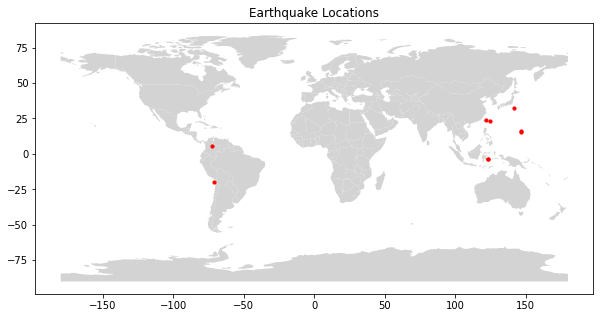

In [44]:
# Step 4: Alternaitive Visualize Earthquake Location Using Geopandas

# Assuming `data` is your JSON object loaded from the USGS API response
# Convert earthquake data into a list of Shapely Point objects
points = [Point(earthquake['geometry']['coordinates'][0], earthquake['geometry']['coordinates'][1]) 
          for earthquake in data['features']]

# Create a GeoDataFrame from the points and set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(geometry=points, crs='EPSG:4326')

# Create a simple base map (world map) - you can customize this as needed
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=10)
plt.title('Earthquake Locations')
plt.show()

